In [1]:
import torch
import gymnasium    
import numpy as np
from differentiable_representation import NystromFeatureExtractor
from differentiable_dynamics import Pendulum3D

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
env = gymnasium.make('Pendulum-v1')
feature_extractor = NystromFeatureExtractor(env)

In [4]:
pendulum_3d = Pendulum3D()

In [4]:
env = gymnasium.make('Pendulum-v1')
feature_extractor = NystromFeatureExtractor(env)
feature_extractor.set_dynamics(pendulum_3d)
sprime, fsa = feature_extractor.random_sample_sprime_fsa()

### Check fast calculation of kernel matrix
Should only work for symmetric kernel.

In [9]:
K1 = feature_extractor.get_kernel_matrix_asymmetric(sprime, fsa)
K2 = feature_extractor.kernel_matrix_torch(sprime, fsa)
torch.equal(torch.from_numpy(K1).float(), K2)

True

In [7]:
m = sprime.shape[0]
n = fsa.shape[0]
dx1 = np.empty((m, n, 3))
for i in np.arange(m):
    for j in np.arange(n):
        dx1[i, j] = sprime[i, :] - fsa[j, :]
dx2 = torch.from_numpy(sprime).unsqueeze(1) - torch.from_numpy(fsa).unsqueeze(0) # k(s', s)
# dx = x1.unsqueeze(1) - x2.unsqueeze(0) # will return the kernel matrix of k(x1, x2) with symmetric kernel.
torch.equal(torch.from_numpy(dx1), dx2)

True

In [29]:
dx2 = np.expand_dims(sprime, axis=1) - np.expand_dims(fsa, axis=0)
np.all(np.equal(dx1, dx2))

True

In [20]:
torch.from_numpy(fsa).unsqueeze(0).size()

torch.Size([1, 512, 3])

### Get nystrom features by SVD for simulator

In [55]:
env = gymnasium.make('Pendulum-v1')
obs = np.vstack([env.observation_space.sample() for i in range(256)])
action = np.vstack([env.action_space.sample() for i in range(256)])
pendulum_3d = Pendulum3D()
pendulum_3d_2 = Pendulum3D(g=12.0, m=2.0, l=2.0)
fsa1 = pendulum_3d.rollout(torch.from_numpy(obs), torch.from_numpy(action))
fsa2 = pendulum_3d_2.rollout(torch.from_numpy(obs), torch.from_numpy(action))

In [56]:
# env = gymnasium.make('Pendulum-v1')
with torch.no_grad(): # for the ground truth
    feature_extractor = NystromFeatureExtractor(env)
    feature_extractor.set_dynamics(pendulum_3d)
    feature_extractor.sample_and_decompose()
    phi = feature_extractor.get_nystrom_feature(fsa1)

In [57]:
feature_extractor2 = NystromFeatureExtractor(env)
feature_extractor2.set_dynamics(pendulum_3d_2)
feature_extractor2.sample_and_decompose()
phi2 = feature_extractor.get_nystrom_feature(fsa2)

In [7]:
torch.equal(phi, phi2)

False

In [58]:
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.Adam([feature_extractor2.rollout_dynamics.g,
                              feature_extractor2.rollout_dynamics.l,
                              feature_extractor2.rollout_dynamics.m])
loss = torch.nn.MSELoss()
data = dict(iter = [], g=[], l=[], m=[])
for i in range(1000):
    fsa2 = pendulum_3d_2.rollout(torch.from_numpy(obs), torch.from_numpy(action))
    phi2 = feature_extractor.get_nystrom_feature(fsa2)
    supervised_loss = loss(phi.detach_(), phi2)
    optimizer.zero_grad()
    supervised_loss.backward()
    optimizer.step()
    data['iter'].append(i)
    data['g'].append(feature_extractor2.rollout_dynamics.g.detach().item())
    data['l'].append(feature_extractor2.rollout_dynamics.l.detach().item())
    data['m'].append(feature_extractor2.rollout_dynamics.m.detach().item())

In [61]:
pendulum_3d_sysid = Pendulum3D(g=12.0, m=2.0, l=2.0)
optimizer_sysid = torch.optim.Adam([pendulum_3d_sysid.g,
                                    pendulum_3d_sysid.l,
                                    pendulum_3d_sysid.m])
data_sysid = dict(iter = [], g=[], l=[], m=[])
for i in range(1000):
    fsa2 = pendulum_3d_sysid.rollout(torch.from_numpy(obs), torch.from_numpy(action))
    sysid_loss = loss(fsa2, fsa1.detach_())
    optimizer_sysid.zero_grad()
    sysid_loss.backward()
    optimizer_sysid.step()
    data_sysid['iter'].append(i)
    data_sysid['g'].append(pendulum_3d_sysid.g.detach().item())
    data_sysid['l'].append(pendulum_3d_sysid.l.detach().item())
    data_sysid['m'].append(pendulum_3d_sysid.m.detach().item())

<AxesSubplot: xlabel='iter', ylabel='l'>

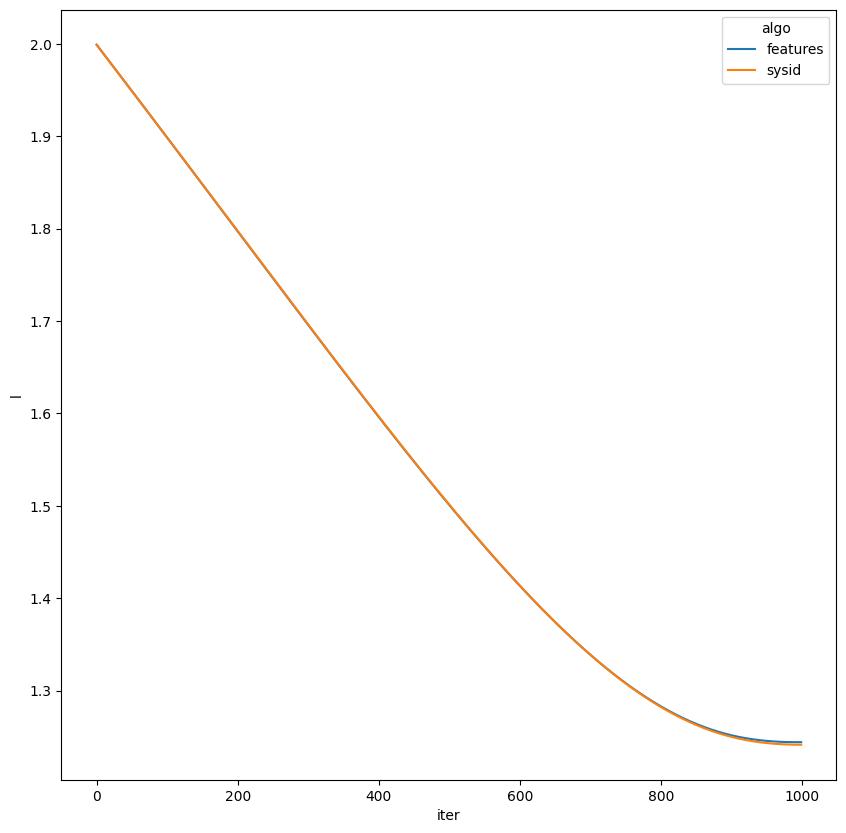

In [62]:
df1 = pd.DataFrame.from_dict(data)
df1['algo'] = 'features'
df2 = pd.DataFrame.from_dict(data_sysid)
df2['algo'] = 'sysid'
df = pd.concat([df1, df2], ignore_index=True)
plt.figure(figsize=[10, 10])
sns.lineplot(df, x='iter', y='l', hue='algo')